In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
import numpy as np

In [3]:
# Load dataset
df = pd.read_csv("commodity-futures-trading-anomaly-detection.csv", parse_dates=['Date'])
df.sort_values('Date', inplace=True)  # Ensure time-series order

In [4]:
df.shape

(371, 32)

In [6]:
columns = []
for column in df.columns:
    columns.append({"Column":column, "Type": df[column].dtype })
columns_df = pd.DataFrame(columns)
columns_df

,Column,Type
0,Id,int64
1,Date,datetime64[ns]
2,Market_participation,float64
3,Producer_merchant_processor_user_longs,float64
4,Producer_merchant_processor_user_shorts,float64
5,Swap_dealer_longs,float64
6,Swap_dealer_shorts,float64
7,Swap_dealer_spreads,float64
8,Money_manager_longs,float64
9,Money_manager_shorts,float64


In [7]:
# Selecting relevant features for prediction
features = [
    "Market_participation", "Producer_merchant_processor_user_longs", 
    "Producer_merchant_processor_user_shorts", "Swap_dealer_longs", 
    "Swap_dealer_shorts", "Swap_dealer_spreads", "Money_manager_longs", 
    "Money_manager_shorts", "Money_manager_spreads", "Other_reportable_longs", 
    "Other_reportable_shorts", "Other_reportable_spreads", "Total_reportable_longs", 
    "Total_reportable_shorts", "Non_reportable_longs", "Non_reportable_shorts", 
    "GOLD", "Net_Producer_Pos", "Net_Swap_Dealer_Pos", "Net_Money_Manager_Pos", 
    "Net_Other_Reportable_Pos", "Price_Change", "SMA_10", "SMA_50"
]

In [8]:
target = "Target_Class"

In [9]:
# Normalize the feature values
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [10]:
# Function to create sequences for RNN
def create_sequences(data, target_col, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size][features].values)
        y.append(data.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

In [11]:
# Define window size
window_size = 10  # Experiment with different sizes

In [12]:
# Create sequences
X, y = create_sequences(df, target, window_size)

In [13]:
print(f"X shape: {X.shape} | Y shape: {y.shape}")

X shape: (361, 10, 24) | Y shape: (361,)


In [14]:
# Splitting dataset (70% train, 15% val, 15% test)
split1 = int(0.7 * len(X))
split2 = int(0.85 * len(X))

In [15]:
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

In [16]:
# Reshape for RNN input (Samples, TimeSteps, Features)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (252, 10, 24), Validation shape: (54, 10, 24), Test shape: (55, 10, 24)


In [17]:
shapes = []

shapes.append({"label": "X shape", "shape": X.shape})
shapes.append({"label": "Y shape", "shape": y.shape})
shapes.append({"label": "Train shape", "shape": X_train.shape})
shapes.append({"label": "Validation shape", "shape": X_val.shape})
shapes.append({"label": "Test shape", "shape": X_test.shape})

shapes_df = pd.DataFrame(shapes)

In [18]:
shapes_df

,label,shape
0,X shape,"(361, 10, 24)"
1,Y shape,"(361,)"
2,Train shape,"(252, 10, 24)"
3,Validation shape,"(54, 10, 24)"
4,Test shape,"(55, 10, 24)"


In [19]:
shapes_df.to_csv("Data/commodity-futures-trading-anomaly-detection-predict-target-class-shapes.csv")

In [20]:
# Building the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,745 (139.63 KB)

 Trainable params: 35,745 (139.63 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=32
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.4870 - loss: 0.6940 - val_accuracy: 0.4630 - val_loss: 0.6926
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4897 - loss: 0.6930 - val_accuracy: 0.4444 - val_loss: 0.6987
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5637 - loss: 0.6888 - val_accuracy: 0.4259 - val_loss: 0.6998
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5087 - loss: 0.6912 - val_accuracy: 0.5185 - val_loss: 0.6951
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5104 - loss: 0.6975 - val_accuracy: 0.4444 - val_loss: 0.6976
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5212 - loss: 0.6893 - val_accuracy: 0.4815 - val_loss: 0.6952
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5908 - loss: 0.6855 - val_accuracy: 0.4815 - val_loss: 0.6960
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5203 - loss: 0.6916 - val_accuracy: 0.5370 - val_loss: 0.6943

In [29]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4852 - loss: 0.7013
Test Accuracy: 0.5091


In [30]:
accuracy = []
accuracy.append({"Label": "Test Accuracy", "Value": f"{test_acc:.4f}"})
accuracy_df = pd.DataFrame(accuracy)

In [31]:
accuracy_df

,Label,Value
0,Test Accuracy,0.5091


In [32]:
accuracy_df.to_csv("Data/commodity-futures-trading-anomaly-detection-predict-target-class-model-accuracy.csv")

In [33]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [36]:
# Select key features to plot
features_to_plot = ['GOLD', 'Price_Change', 'Net_Producer_Pos', 'Net_Money_Manager_Pos', 'Target_Class']

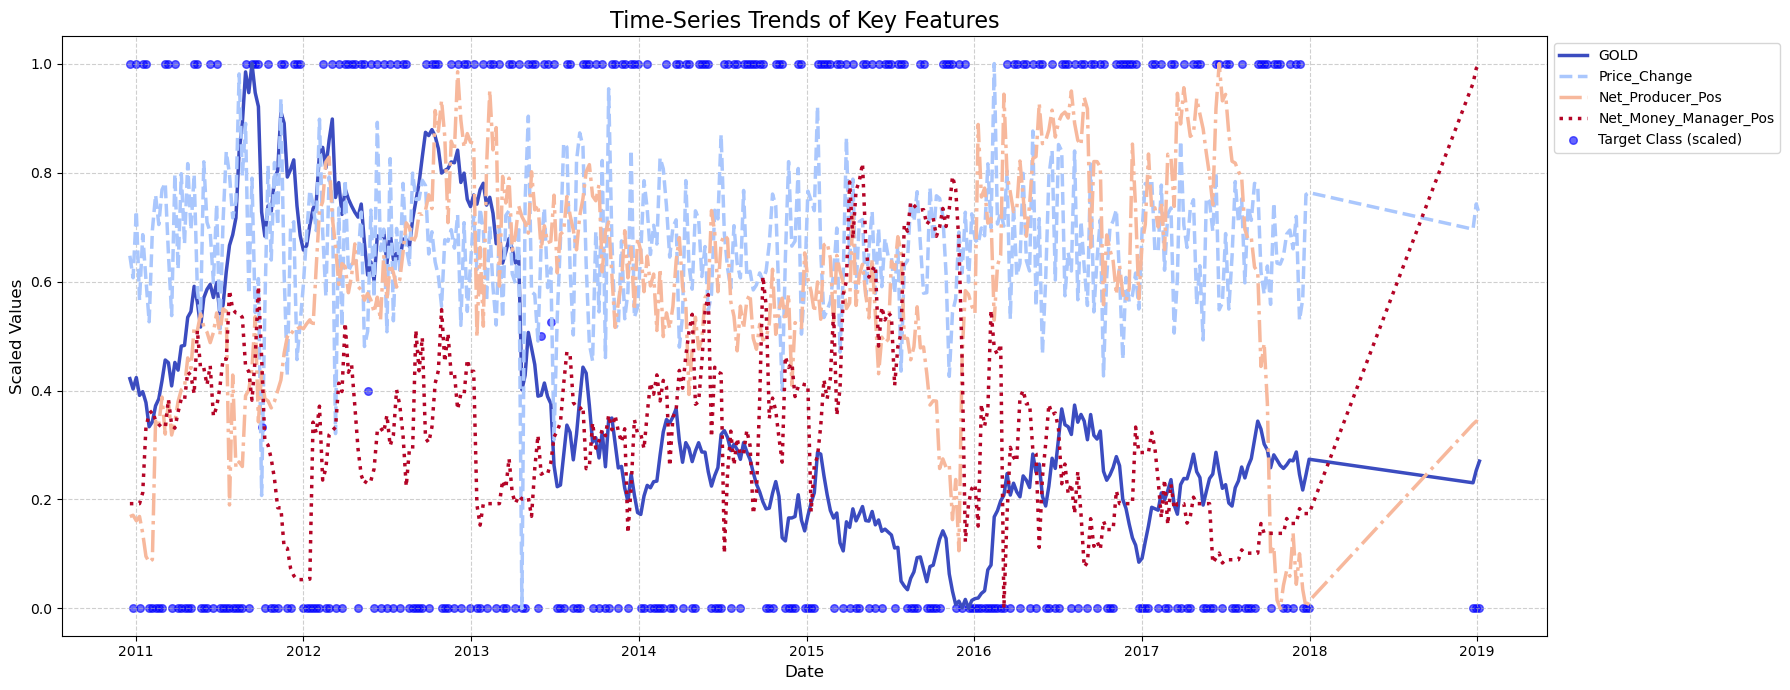

In [38]:
plt.figure(figsize=(18, 7))  # Slightly larger figure for better readability

# Plot features with distinct colors and linestyles
num_features = len(features_to_plot) - 1
colors = plt.cm.coolwarm(np.linspace(0, 1, num_features))  # Use np.linspace
linestyles = ["-", "--", "-.", ":", "-", "--", "-."]  # Add more if needed

for i, feature in enumerate(features_to_plot[:-1]):  # Exclude Target_Class
    plt.plot(
        df.index,
        df[feature],
        label=feature,
        color=colors[i % num_features],  # Cycle through colors
        linestyle=linestyles[i % len(linestyles)], #cycle through linestyles
        linewidth=2.5,
    )

# Plot Target_Class as a scatter plot
max_gold = df["GOLD"].max()
plt.scatter(
    df.index,
    df["Target_Class"] * max_gold,
    color="blue",
    label="Target Class (scaled)",
    alpha=0.6,
    s=30,  # Adjust marker size
)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.title("Time-Series Trends of Key Features", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Scaled Values", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.tight_layout() #avoid labels being cutoff
plt.savefig("Plots/Time-Series Trends of Key Features.png", dpi=200)
plt.show()

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x500 with 0 Axes>

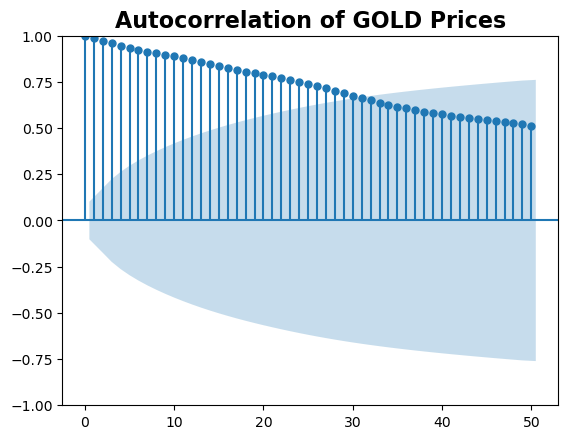

In [44]:
plt.figure(figsize=(12, 5))
plot_acf(df['GOLD'].dropna(), lags=50)  # Check past 50 lags
plt.title("Autocorrelation of GOLD Prices", fontweight='bold', fontsize=16)
plt.show()

<Figure size 1200x500 with 0 Axes>

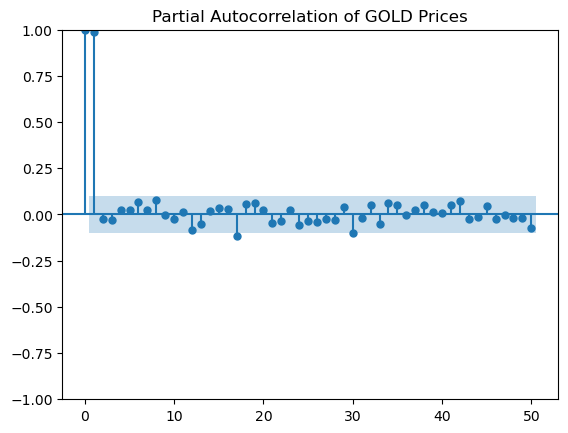

In [45]:
plt.figure(figsize=(12, 5))
plot_pacf(df['GOLD'].dropna(), lags=50)
plt.title("Partial Autocorrelation of GOLD Prices")
plt.show()

In [46]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [47]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [48]:
# Use TSNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled_features)

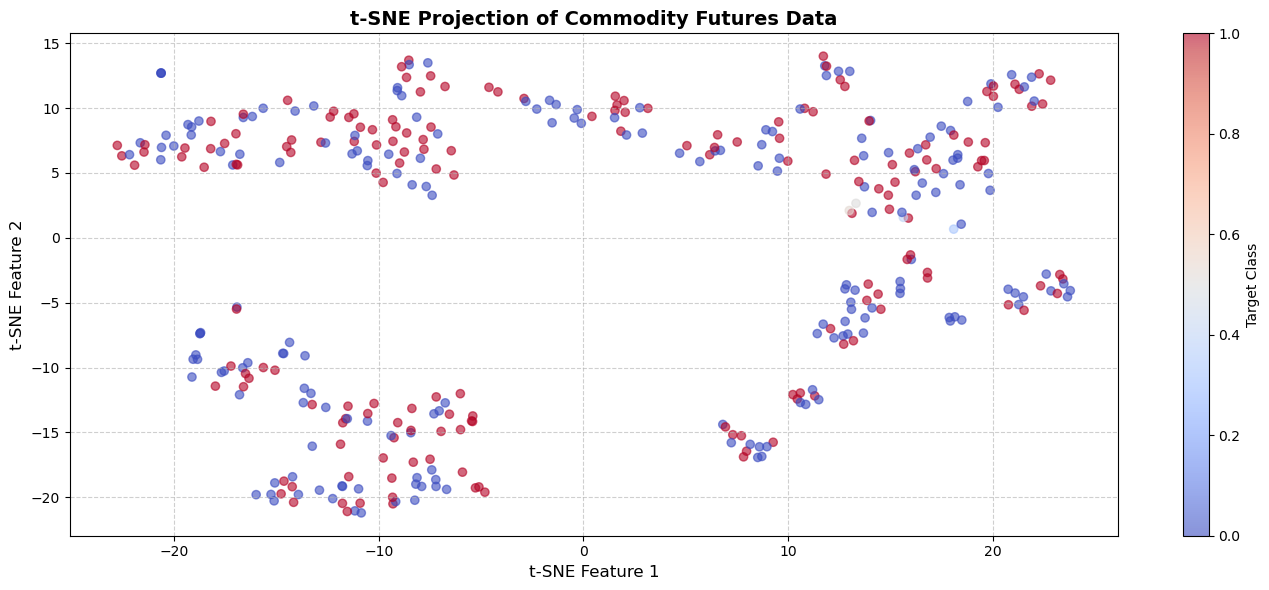

In [49]:
plt.figure(figsize=(14, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['Target_Class'], cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Projection of Commodity Futures Data", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Feature 1", fontsize=12)
plt.ylabel("t-SNE Feature 2", fontsize=12)
plt.colorbar(label="Target Class")
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.tight_layout() #avoid labels being cutoff
plt.savefig("Plots/t-SNE Projection of Commodity Futures Data.png", dpi=200)
plt.show()